In [46]:
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
import numpy as np
import pickle
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from data.load_data_from_sql import connect_to_database, read_sql_to_dataframe, close_connection
from scripts.cleaner import DataCleaner
from scripts.utils import Utils
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

cleaner = DataCleaner()
utility = Utils()
%matplotlib inline

In [19]:
# Function to add the project path to sys.path
def add_project_path():
    """Add the project path to sys.path."""
    project_path = 'C:\\Users\\user\\Desktop\\10 acc\\Week 1\\User-Analytics-in-Telecom-Industry'
    sys.path.append(project_path)

In [20]:
# Function to perform the main analysis
def main_analysis(table_name):
    """Main function to execute your analysis."""
    # Add the project path to sys.path
    add_project_path()

    db_params = {
        'dbname': 'week-1',
        'user': 'postgres',
        'password': 'postgres',
        'host': 'localhost',
        'port': '5432',
    }

    # Example query
    query = f"SELECT * FROM {table_name};"

    # Connect to the database
    conn = connect_to_database(db_params)

    # Read results into a Pandas DataFrame
    cleaned_df = read_sql_to_dataframe(conn, query)

    # Close the database connection
    close_connection(conn)


    # return the DataFrame
    return cleaned_df

In [23]:
cleaned_df = main_analysis('cleaned_telecom_data')
engagement_metric = main_analysis('engagement_metric')
experience_metric = main_analysis('experience_metric')
engagement_metric.head()

INFO:data.load_data_from_sql:connect_to_database executed successfully.


C:\Users\user\Desktop\10 acc\Week 1\User-Analytics-in-Telecom-Industry\data\load_data_from_sql.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
INFO:data.load_data_from_sql:read_sql_to_dataframe executed successfully.
INFO:data.load_data_from_sql:close_connection executed successfully.
INFO:data.load_data_from_sql:connect_to_database executed successfully.
C:\Users\user\Desktop\10 acc\Week 1\User-Analytics-in-Telecom-Industry\data\load_data_from_sql.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
INFO:data.load_data_from_sql:read_sql_to_dataframe executed successfully.
INFO:data.load_data_from_sql:

,msisdn/number,session_traffic(bytes),session_duration(ms),session_freq,cluster,score
0,3.360100e+10,8.786906e+08,116720.0,1.0,0,0.000057
1,3.360100e+10,1.568596e+08,181230.0,1.0,1,0.000965
2,3.360100e+10,5.959665e+08,134969.0,1.0,0,0.000036
3,3.360101e+10,4.223207e+08,49878.0,1.0,0,0.000072
4,3.360101e+10,1.457411e+09,37104.0,2.0,0,0.000165


#### Satisfaction score

In [25]:
engagement_metric.rename(columns={"score": "engagement_score"}, inplace=True)
experience_metric.rename(columns={"score": "experience_score"}, inplace=True)
engagement_metric.rename(columns={"msisdn/number": "msisdn"}, inplace=True)
user_satisfaction_metrics = pd.merge(engagement_metric, experience_metric, on="msisdn")
user_satisfaction_metrics['satisfaction_score'] = user_satisfaction_metrics[['engagement_score','experience_score']].mean(axis=1)
score_df = user_satisfaction_metrics[['msisdn', 'satisfaction_score','engagement_score', 'experience_score']]
score_df['msisdn'] = score_df['msisdn'].astype(str)
score_df = cleaner.remove_nan_categorical(score_df)
score_df.head()


C:\Users\user\AppData\Local\Temp\ipykernel_10628\3085863915.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_df['msisdn'] = score_df['msisdn'].astype(str)
INFO:scripts.cleaner:get_categorical_columns executed successfully.
INFO:scripts.cleaner:remove_nan_categorical executed successfully.


,msisdn,satisfaction_score,engagement_score,experience_score
0,33601001722.0,0.000077,0.000057,0.000096
1,33601001754.0,0.000531,0.000965,0.000096
2,33601002511.0,0.000066,0.000036,0.000096
3,33601007832.0,0.000092,0.000072,0.000113
4,33601008617.0,0.000165,0.000165,0.000165


### top 10 satisfied customers

In [26]:
top_10_satisfied = score_df.sort_values(by=['satisfaction_score'], ascending=False).head(10)
top_10_satisfied

,msisdn,satisfaction_score,engagement_score,experience_score
1,33601001754.0,0.000531,0.000965,0.000096
4,33601008617.0,0.000165,0.000165,0.000165
5,33601008617.0,0.000130,0.000165,0.000096
3,33601007832.0,0.000092,0.000072,0.000113
0,33601001722.0,0.000077,0.000057,0.000096
2,33601002511.0,0.000066,0.000036,0.000096


In [27]:
score_df.describe()

,satisfaction_score,engagement_score,experience_score
count,6.000000,6.000000,6.000000
mean,0.000177,0.000243,0.000110
std,0.000177,0.000358,0.000028
min,0.000066,0.000036,0.000096
25%,0.000081,0.000061,0.000096
50%,0.000111,0.000118,0.000096
75%,0.000156,0.000165,0.000109
max,0.000531,0.000965,0.000165


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


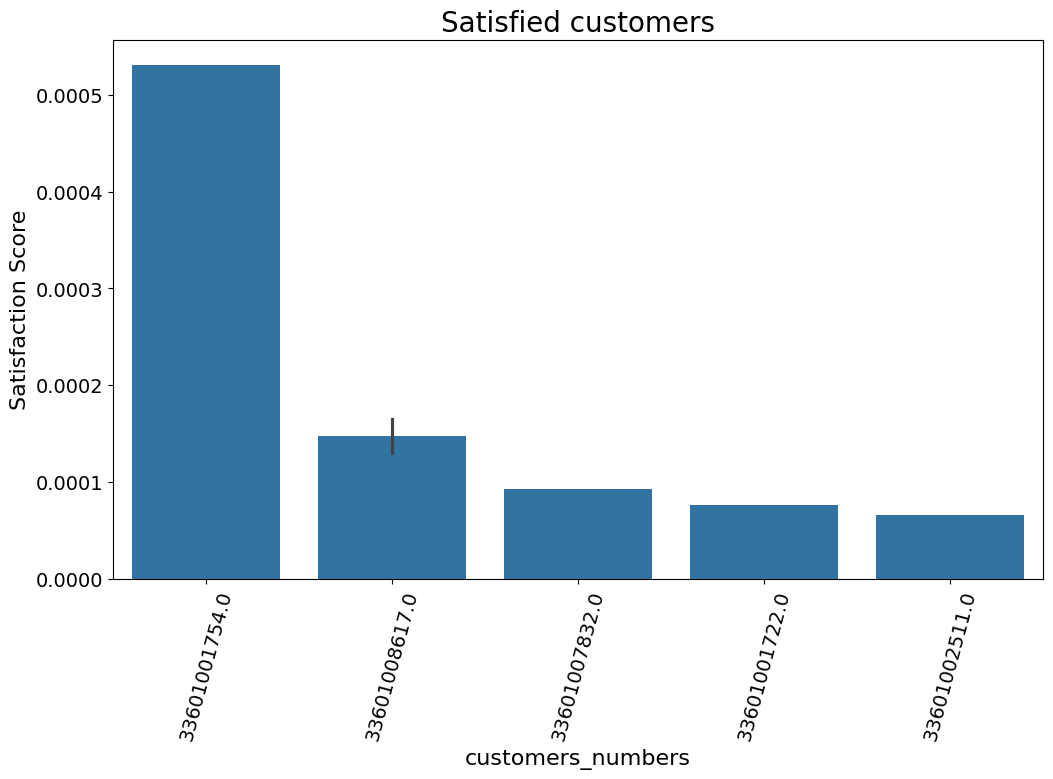

In [28]:
utility.plot_bar(df=top_10_satisfied[['msisdn','satisfaction_score']],title="Satisfied customers",x_col="msisdn",y_col="satisfaction_score",xlabel="customers_numbers",ylabel="Satisfaction Score")

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


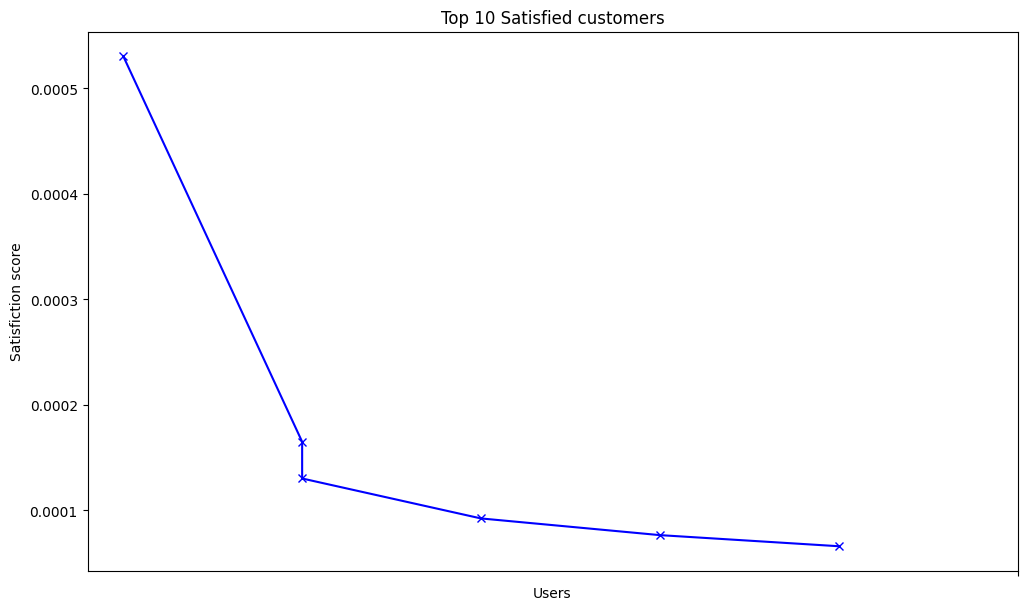

In [29]:
plt.figure(figsize=(12, 7))
plt.plot(top_10_satisfied['msisdn'],top_10_satisfied['satisfaction_score'],'bx-')
plt.xlabel('Users') 
plt.xticks(ticks=[''])
plt.ylabel('Satisfiction score') 
plt.title('Top 10 Satisfied customers')
plt.show()


### Modeling (Regression Model)

In [30]:
col_rearrange=['msisdn','handset_type','session_traffic(bytes)','session_duration(ms)','session_freq','total_rtt(ms)','total_tp(kbps)','total_tcp(bytes)','engagement_score','experience_score','satisfaction_score']
user_satisfaction_metrics_rearranged=user_satisfaction_metrics[col_rearrange]
user_satisfaction_metrics_rearranged

,msisdn,handset_type,session_traffic(bytes),session_duration(ms),session_freq,total_rtt(ms),total_tp(kbps),total_tcp(bytes),engagement_score,experience_score,satisfaction_score
0,3.360100e+10,Huawei P20 Lite Huawei Nova 3E,8.786906e+08,116720.0,1.0,46.0,76.0,589679.5,0.000057,0.000096,0.000077
1,3.360100e+10,Apple iPhone 7 (A1778),1.568596e+08,181230.0,1.0,31.0,99.0,589679.5,0.000965,0.000096,0.000531
2,3.360100e+10,undefined,5.959665e+08,134969.0,1.0,50.0,97.0,589679.5,0.000036,0.000096,0.000066
3,3.360101e+10,Apple iPhone 5S (A1457),4.223207e+08,49878.0,1.0,84.0,248.0,22015.5,0.000072,0.000113,0.000092
4,3.360101e+10,Apple iPhone Se (A1723),1.457411e+09,37104.0,2.0,91.0,56781.0,9370832.0,0.000165,0.000165,0.000165
5,3.360101e+10,Apple iPhone Se (A1723),1.457411e+09,37104.0,2.0,28.0,63.0,589679.5,0.000165,0.000096,0.000130


In [31]:
user_satisfaction_metrics_rearranged.corr()

C:\Users\user\AppData\Local\Temp\ipykernel_10628\3904277266.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  user_satisfaction_metrics_rearranged.corr()


,msisdn,session_traffic(bytes),session_duration(ms),session_freq,total_rtt(ms),total_tp(kbps),total_tcp(bytes),engagement_score,experience_score,satisfaction_score
msisdn,1.000000,0.631875,-0.940135,0.760238,0.502171,0.481843,0.450114,-0.362135,0.582140,-0.320039
session_traffic(bytes),0.631875,1.000000,-0.738676,0.900925,0.148635,0.568630,0.584829,-0.491031,0.490038,-0.457493
session_duration(ms),-0.940135,-0.738676,1.000000,-0.715183,-0.534172,-0.453180,-0.423470,0.618204,-0.547515,0.581441
session_freq,0.760238,0.900925,-0.715183,1.000000,0.130852,0.631556,0.643308,-0.170299,0.566601,-0.127470
total_rtt(ms),0.502171,0.148635,-0.534172,0.130852,1.000000,0.664057,0.618370,-0.425711,0.807100,-0.366569
total_tp(kbps),0.481843,0.568630,-0.453180,0.631556,0.664057,1.000000,0.997869,-0.108175,0.970825,-0.032918
total_tcp(bytes),0.450114,0.584829,-0.423470,0.643308,0.618370,0.997869,1.000000,-0.091185,0.953112,-0.017148
engagement_score,-0.362135,-0.491031,0.618204,-0.170299,-0.425711,-0.108175,-0.091185,1.000000,-0.167884,0.996989
experience_score,0.582140,0.490038,-0.547515,0.566601,0.807100,0.970825,0.953112,-0.167884,1.000000,-0.090941
satisfaction_score,-0.320039,-0.457493,0.581441,-0.127470,-0.366569,-0.032918,-0.017148,0.996989,-0.090941,1.000000


C:\Users\user\AppData\Local\Temp\ipykernel_10628\2037030984.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(user_satisfaction_metrics_rearranged.corr(),cmap="YlGnBu")


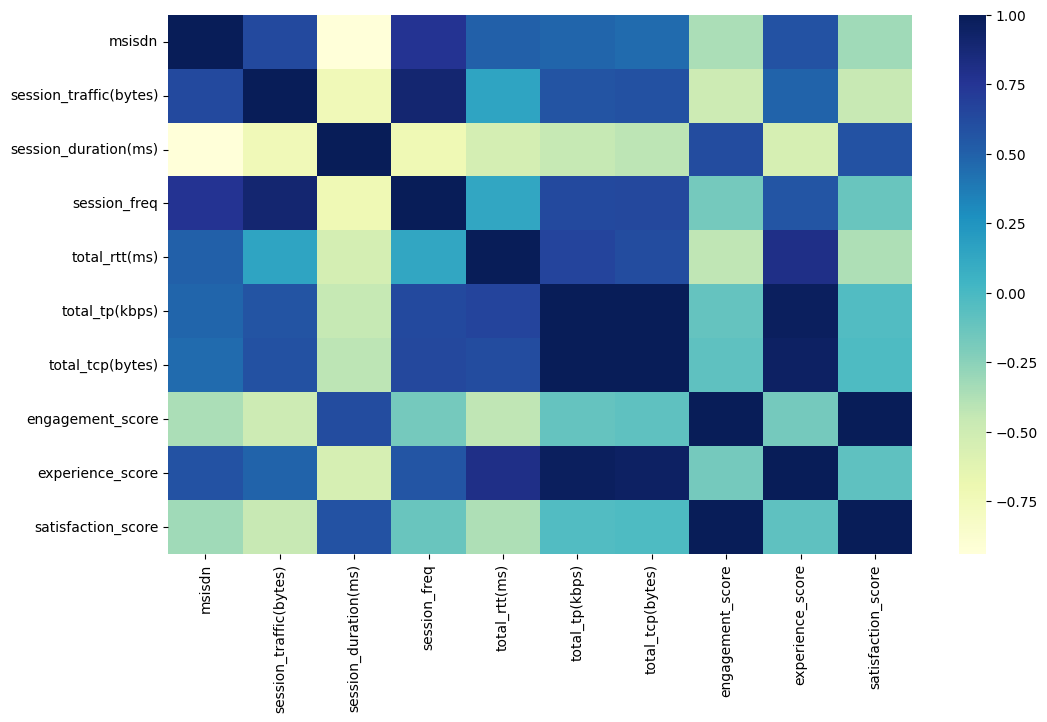

In [32]:
plt.figure(figsize=(12, 7))
sns.heatmap(user_satisfaction_metrics_rearranged.corr(),cmap="YlGnBu")
plt.show()

from the above heatmap we can see that total_rtt is less correlated with other features and msisdn, obviously is the least correlated with the others <br>
handset types was not included in the correlation because it is categorical column we shall apply label encoding

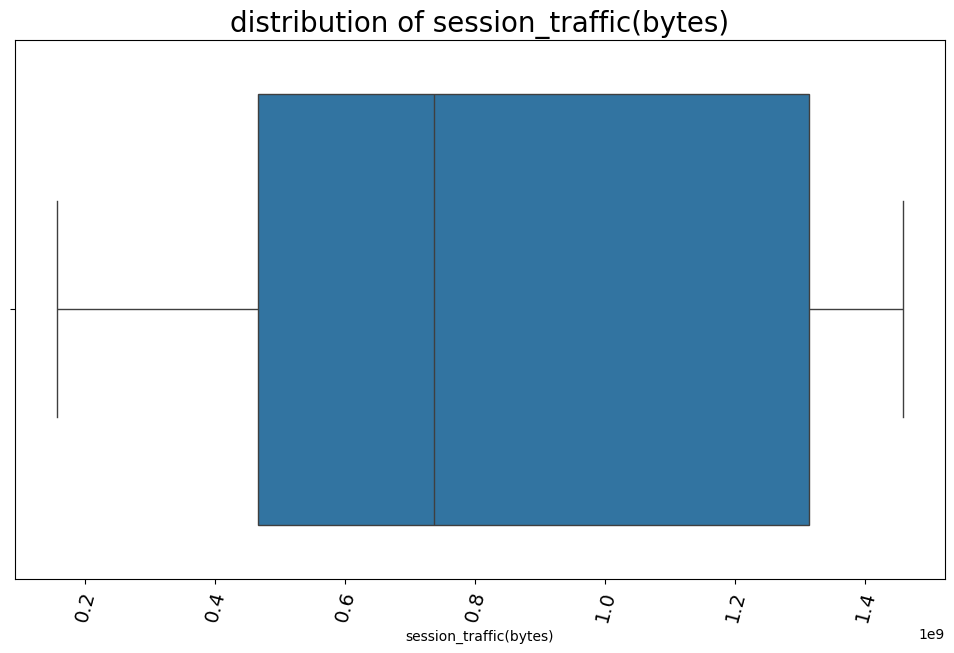

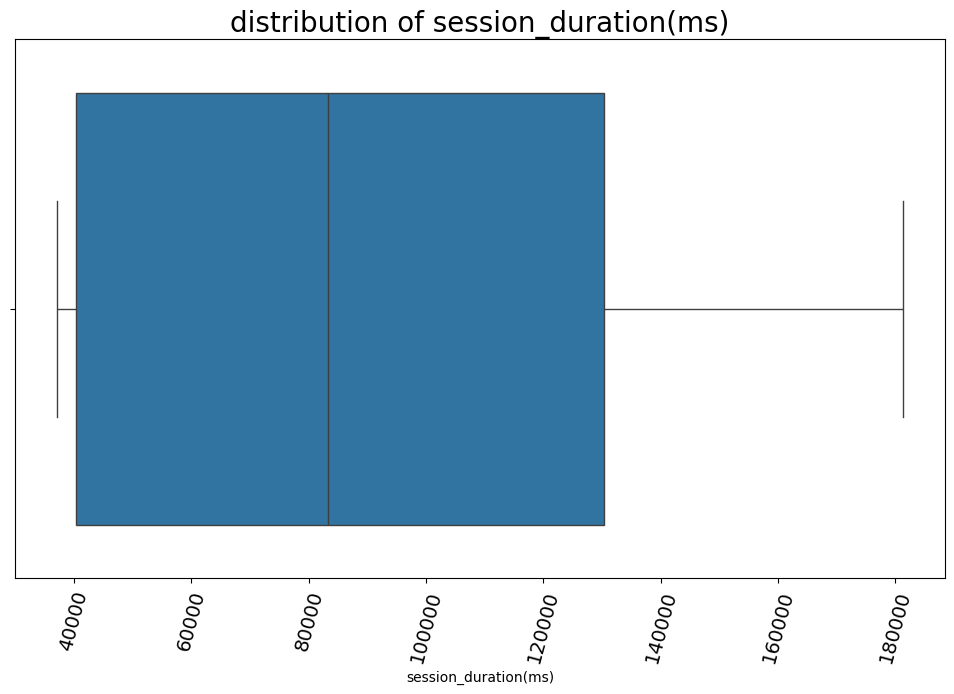

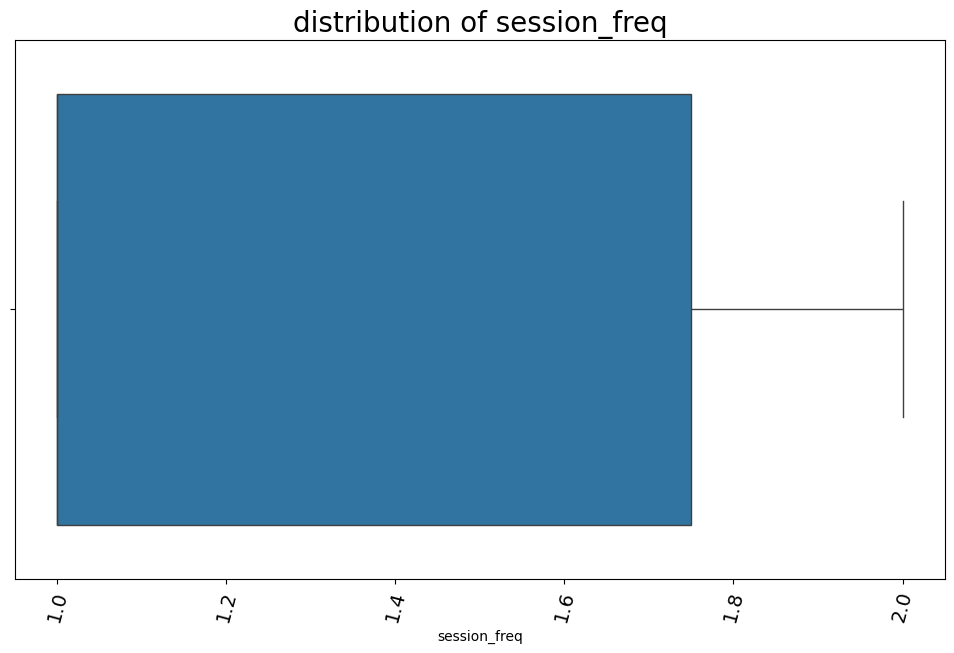

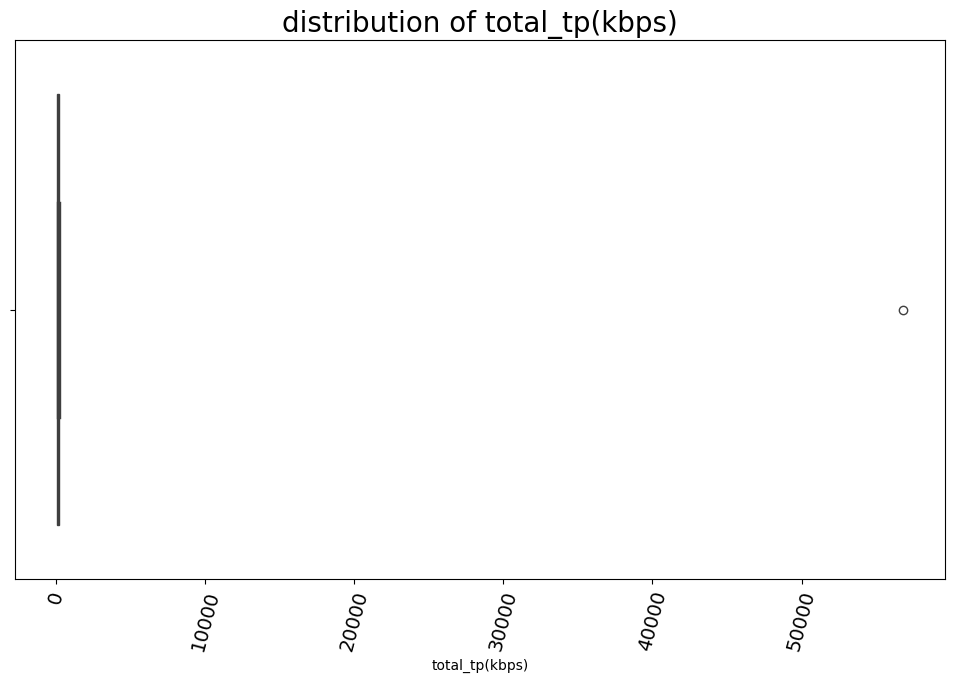

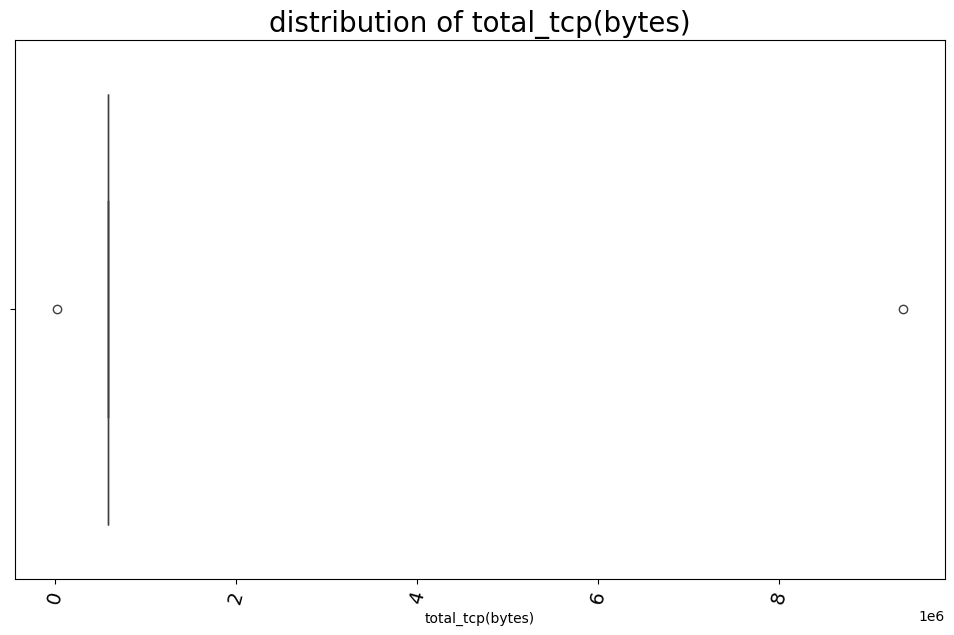

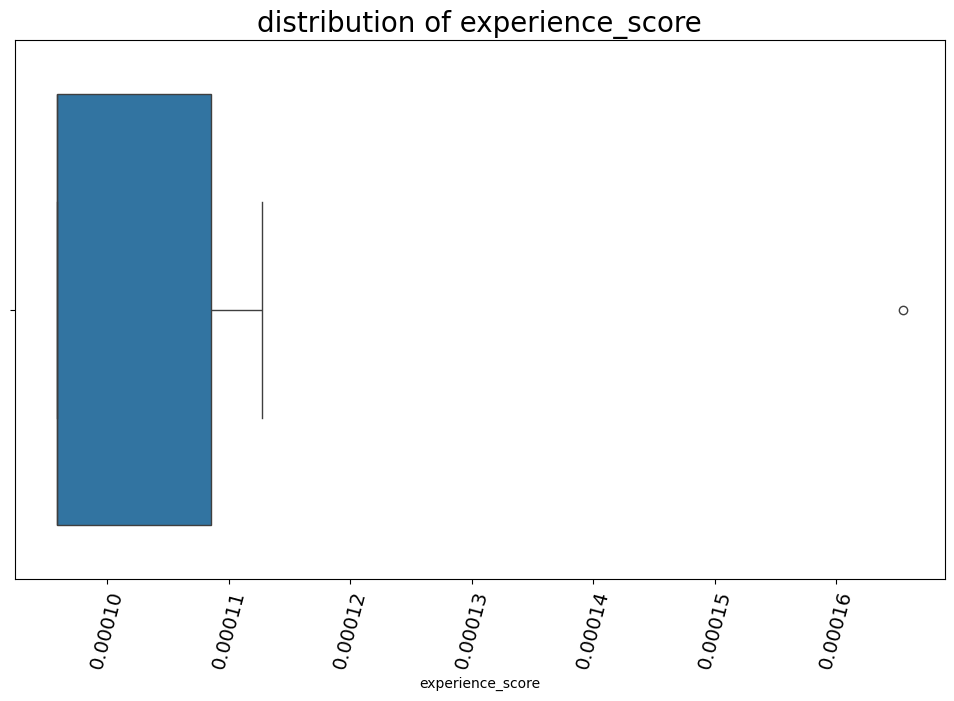

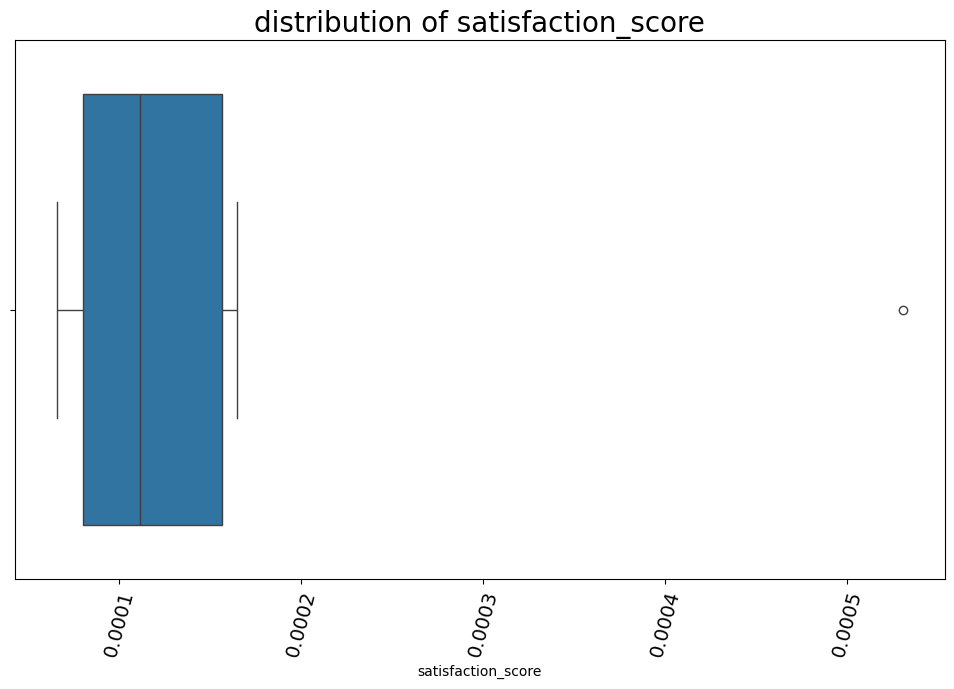

In [33]:
utility.plot_box(user_satisfaction_metrics_rearranged,'session_traffic(bytes)','distribution of session_traffic(bytes)')
utility.plot_box(user_satisfaction_metrics_rearranged,'session_duration(ms)','distribution of session_duration(ms)')
utility.plot_box(user_satisfaction_metrics_rearranged,'session_freq','distribution of session_freq')
utility.plot_box(user_satisfaction_metrics_rearranged,'total_tp(kbps)','distribution of total_tp(kbps)')
utility.plot_box(user_satisfaction_metrics_rearranged,'total_tcp(bytes)','distribution of total_tcp(bytes)')
utility.plot_box(user_satisfaction_metrics_rearranged,'experience_score','distribution of experience_score')
utility.plot_box(user_satisfaction_metrics_rearranged,'satisfaction_score','distribution of satisfaction_score')

we should handle outliers before feeding to the model

In [34]:
score_df

,msisdn,satisfaction_score,engagement_score,experience_score
0,33601001722.0,0.000077,0.000057,0.000096
1,33601001754.0,0.000531,0.000965,0.000096
2,33601002511.0,0.000066,0.000036,0.000096
3,33601007832.0,0.000092,0.000072,0.000113
4,33601008617.0,0.000165,0.000165,0.000165
5,33601008617.0,0.000130,0.000165,0.000096


In [35]:
# cleaned_score_df= cleaner.handle_outliers(score_df,'session_freq')
# cleaned_score_df= cleaner.handle_outliers(cleaned_score_df,'total_tp(kbps)')
# cleaned_score_df= cleaner.handle_outliers(cleaned_score_df,'total_tcp(bytes)')
cleaned_score_df= cleaner.handle_outliers(score_df,'experience_score')
cleaned_score_df= cleaner.handle_outliers(cleaned_score_df,'engagement_score')
# cleaned_score_df= cleaner.handle_outliers(cleaned_score_df,'satisfaction_score')

INFO:scripts.cleaner:handle_outliers executed successfully.
INFO:scripts.cleaner:handle_outliers executed successfully.


In [38]:
le = LabelEncoder()
label_encoded_satisfaction_metrics = cleaned_score_df.copy()
for col in label_encoded_satisfaction_metrics.select_dtypes(include='O').columns:
    label_encoded_satisfaction_metrics[col]=le.fit_transform(label_encoded_satisfaction_metrics[col])

In [39]:
label_encoded_satisfaction_metrics.corr()

,msisdn,satisfaction_score,engagement_score,experience_score
msisdn,1.000000,-0.244958,0.028052,0.586183
satisfaction_score,-0.244958,1.000000,0.938612,-0.151733
engagement_score,0.028052,0.938612,1.000000,-0.023409
experience_score,0.586183,-0.151733,-0.023409,1.000000


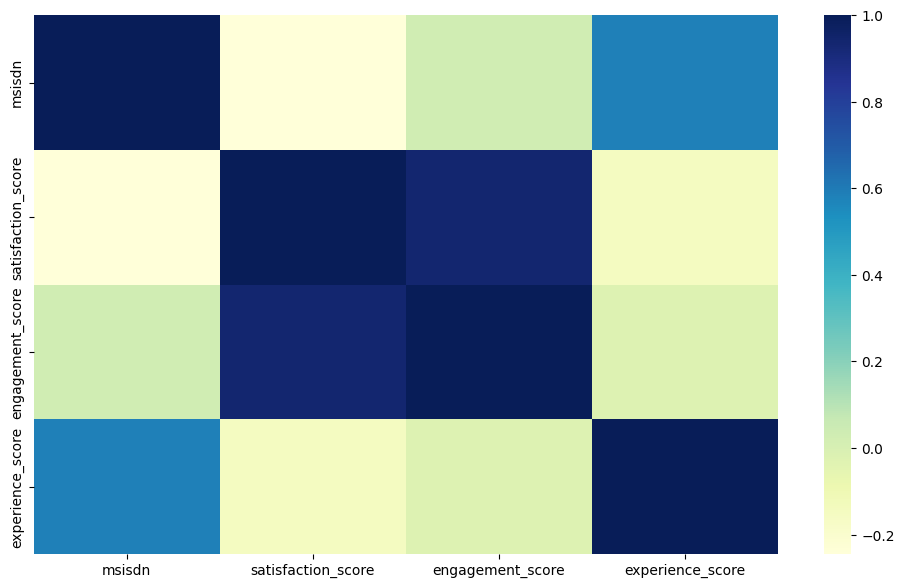

In [40]:
plt.figure(figsize=(12, 7))
sns.heatmap(label_encoded_satisfaction_metrics.corr(),cmap="YlGnBu")
plt.show()

In [41]:
# Normalize the data before clustering
normalized_score_df = cleaner.normalizer(cleaned_score_df)

INFO:scripts.cleaner:get_numerical_columns executed successfully.
INFO:scripts.cleaner:get_numerical_columns executed successfully.
INFO:scripts.cleaner:normalizer executed successfully.


In [42]:
cleaned_score_df

,msisdn,satisfaction_score,engagement_score,experience_score
0,33601001722.0,0.000077,0.000057,0.000096
1,33601001754.0,0.000531,0.000320,0.000096
2,33601002511.0,0.000066,0.000036,0.000096
3,33601007832.0,0.000092,0.000072,0.000113
4,33601008617.0,0.000165,0.000165,0.000128
5,33601008617.0,0.000130,0.000165,0.000096


Build Our Model

In [43]:
# Get X and Y values for the regression model
X = normalized_score_df.loc[:,normalized_score_df.columns!="satisfaction_score" ]
# X = normalized_score_df[normalized_score_df.columns.difference(['experience_score','engagement_score','satisfaction_score'])]
# X = normalized_score_df[label_encoded_satisfaction_metrics.columns.difference(['satisfaction_score'])]
# Y = normalized_score_df[['experience_score','engagement_score','satisfaction_score']]
Y = normalized_score_df[['satisfaction_score']]

scaler=StandardScaler()
X_data=scaler.fit_transform(X)
y_data=Y.to_numpy()

# Split inpute data into train and test

x_train, x_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=10)

reg = LinearRegression()

model = reg.fit(x_train, y_train)
pred = model.predict(x_test)

In [44]:
# model.score(x_test,y_test)
pred

array([[0.56956291],
       [0.6223936 ]])

In [47]:
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=10).fit(normalized_score_df)
pred = kmeans.predict(normalized_score_df)

score_df_with_cluster = score_df.copy()
score_df_with_cluster['cluster'] = pred
score_df_with_cluster['cluster'].value_counts()

norm_score = normalized_score_df.copy()
norm_score['cluster'] = pred

c:\Users\user\Desktop\10 acc\Week 1\User-Analytics-in-Telecom-Industry\week-1\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


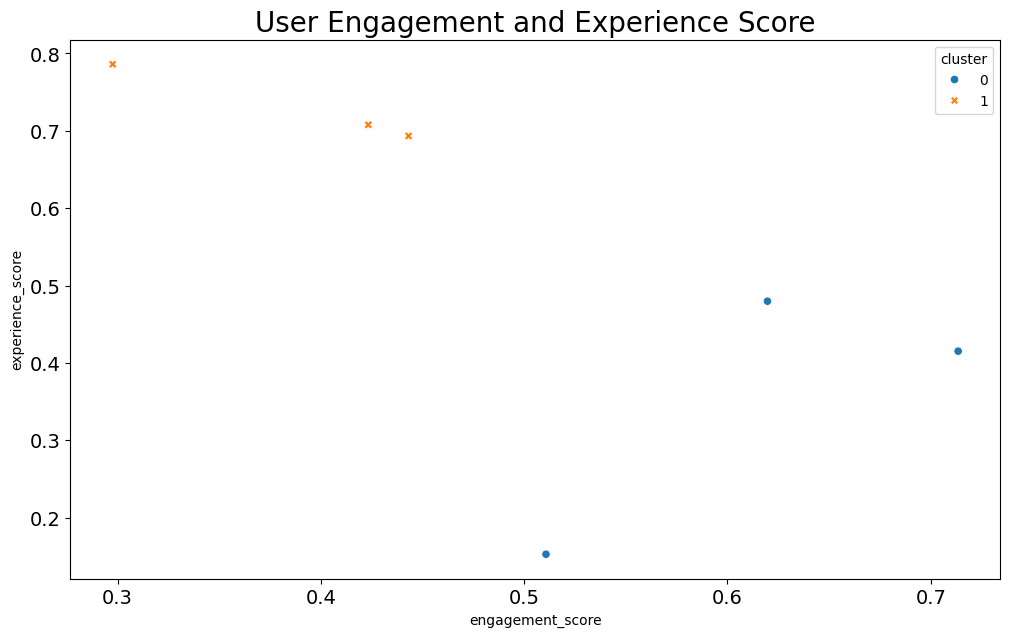

INFO:scripts.utils:plot_scatter executed successfully.


In [48]:
utility.plot_scatter(norm_score,'engagement_score', 'experience_score', 'User Engagement and Experience Score','cluster','cluster')

In [49]:
avg_cluster_scores = score_df_with_cluster.groupby(['cluster']).mean()
avg_cluster_scores.head()

C:\Users\user\AppData\Local\Temp\ipykernel_10628\2586319653.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_cluster_scores = score_df_with_cluster.groupby(['cluster']).mean()


,satisfaction_score,engagement_score,experience_score
cluster,,,
0,0.000275,0.000432,0.000119
1,0.000078,0.000055,0.000102


In [50]:
agg_data = {}
agg_data['top_10_satisfied'] = top_10_satisfied
pickle.dump(agg_data, open('../data/satisfaction_data.pkl', 'wb'))